In [520]:
import pandas as pd
import numpy as np
import warnings

import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #масштабирование признаков

warnings.filterwarnings('ignore')

In [521]:
df = pd.read_csv('masterskaya_id_info.csv')

In [522]:
df = df.drop('Unnamed: 0', axis=1)

In [523]:
df.head()

,id,gender,city_category,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,...,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
0,DE5393F9-9585-4057-B7FB-24B69697FC08,женский,Москва,2020-12-30 11:42:20,2022-07-03 19:49:48,21,3500.0,166.666667,100.0,73.080738,...,43.098897,-1,500.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0
1,81CD4BEF-443E-4D36-B34F-664E11182D65,женский,Москва,2019-10-11 09:03:12,2022-04-29 17:18:36,11,4200.0,381.818182,400.0,28.203597,...,108.203897,0,500.0,0.181818,0.636364,0.0,0.181818,0.181818,0.818182,0.0
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,мужской,Город неизвестен,2022-04-07 00:00:00,2022-07-07 00:00:00,3,63.0,21.000000,16.0,0.000000,...,39.925147,0,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
3,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,женский,Город неизвестен,2020-12-26 01:25:32,2022-07-26 01:25:45,18,3600.0,200.000000,200.0,26.069164,...,20.865599,2,400.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0
4,6FDEE73B-0270-4AFA-BA21-579E5B970D6A,женский,Город неизвестен,2017-08-26 18:16:27,2019-03-26 18:20:06,18,1800.0,100.000000,100.0,28.237902,...,1238.161189,2,200.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0


### Новые жертвователи
Условия:
* первый платеж совершен от полугода до года назад.

Для этих пользователей предскажем дальнейшее поведение.

In [524]:
#Выделим новых жертвователей в отдельный датасет
df_new = df[(df['first_donation']>=182) & (df['first_donation']<=365)]
df_new.info()
display(df_new.describe())
#sns.heatmap(df_new.pivot_table(values="id",aggfunc="count",index='donations_sum',columns='lifetime'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 61 to 904
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          30 non-null     object 
 1   gender                      30 non-null     object 
 2   city_category               30 non-null     object 
 3   first_date                  30 non-null     object 
 4   last_date                   30 non-null     object 
 5   donations_count             30 non-null     int64  
 6   donations_sum               30 non-null     float64
 7   donations_mean              30 non-null     float64
 8   donations_median            30 non-null     float64
 9   last_email_activity         30 non-null     float64
 10  is_reccurent                30 non-null     int64  
 11  lifetime                    30 non-null     float64
 12  period                      30 non-null     float64
 13  first_donation              30 non-

,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000
mean,5.233333,4166.033333,661.921789,647.433333,24.808263,0.300000,161.733333,35.816609,289.253406,127.325478,0.066667,228.333333,0.851515,0.012121,0.0,0.136364,0.587879,0.012121,0.400000
std,3.318530,8341.454866,931.497631,950.403750,50.072459,0.466092,103.674202,29.382898,48.989612,103.501033,0.583292,1038.208282,0.346364,0.066391,0.0,0.344934,0.492597,0.066391,0.498273
min,2.000000,60.000000,10.000000,10.000000,0.000000,0.000000,13.000000,4.750000,185.925147,20.365541,-2.000000,-400.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,2.000000,731.250000,276.136364,300.000000,0.000000,0.000000,56.500000,23.550000,263.675147,41.732960,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1600.000000,420.000000,400.000000,25.644256,0.000000,192.000000,27.400000,295.824279,90.701571,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
75%,8.750000,3750.000000,731.250000,612.500000,28.237786,1.000000,255.500000,42.807143,330.923559,203.046097,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000
max,11.000000,45000.000000,5000.000000,5000.000000,280.114557,1.000000,305.000000,130.000000,363.960738,330.925147,2.000000,5500.000000,1.000000,0.363636,0.0,1.000000,1.000000,0.363636,1.000000


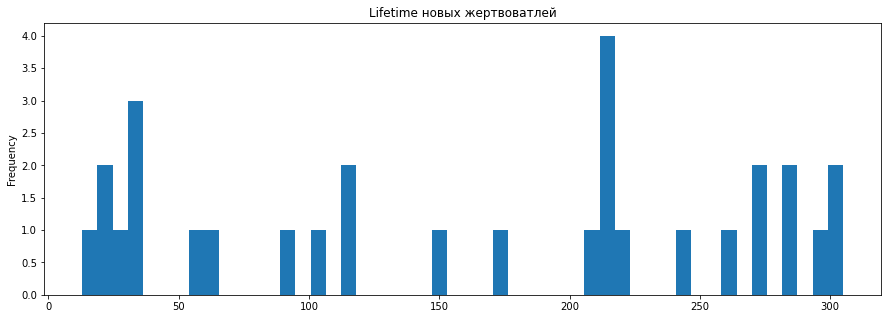

In [525]:
#df_new['lifetime'].plot(title='Lifetime новых жертвоватлей', figsize=(15,5), kind='bar')
df_new['lifetime'].plot(title='Lifetime новых жертвоватлей', figsize=(15,5), kind='hist', bins=50);


In [526]:
# удалим лишние столбцы
df = df.drop(['first_date', 'last_date'], axis=1)

In [527]:
df.columns.to_frame()

,0
id,id
gender,gender
city_category,city_category
donations_count,donations_count
donations_sum,donations_sum
donations_mean,donations_mean
donations_median,donations_median
last_email_activity,last_email_activity
is_reccurent,is_reccurent
lifetime,lifetime


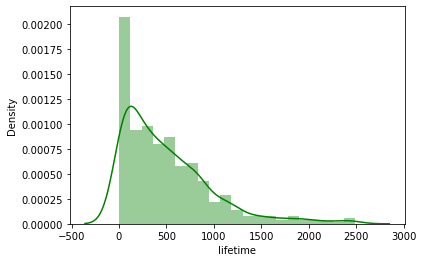

In [528]:
sns.distplot(df['lifetime'], color='green');

<AxesSubplot:>

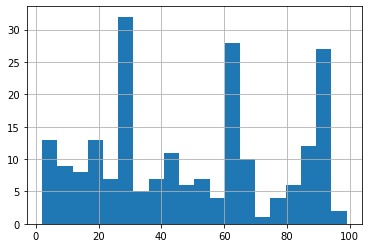

In [529]:
df[df['lifetime']<100]['lifetime'].hist(bins=20)

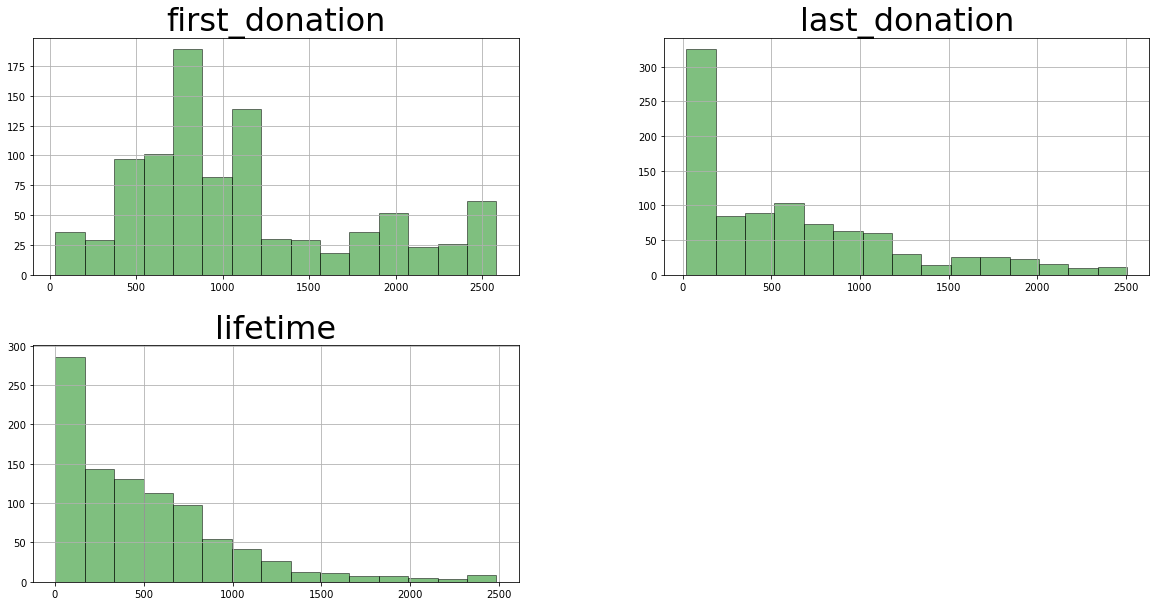

In [530]:
fig = df[['first_donation','last_donation', 'lifetime']].hist(alpha=0.5, figsize=(20,10), bins=15, fc='green',ec="black");
[x.title.set_size(32) for x in fig.ravel()];


In [531]:
print(df[df['lifetime']<100]['id'].count())
df[df['lifetime']<100].sort_values(by=['donations_median','donations_count'], ascending=False).head()

212


,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
927,54EDABBF-B115-477A-A207-1C895815005D,мужской,Другие города России,2,25500.0,12750.000000,12750.0,482.243735,0,45.0,...,490.925147,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
898,B8F67F6A-D78B-4078-9CF6-BC5F4D0E373A,мужской,Город неизвестен,2,21781.0,10890.500000,10890.5,27.919360,0,61.0,...,2401.300344,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
395,F7F24B47-3341-49EB-90D4-AC2E8F4FB320,мужской,Город неизвестен,7,57100.0,8157.142857,10510.0,27.599789,0,58.0,...,921.921282,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
586,EAD75CE6-0F33-478E-A37E-712C66DB9082,женский,Москва,4,40000.0,10000.000000,10000.0,28.237775,1,92.0,...,717.973851,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
942,D4FD3C48-37EA-439F-AAC3-59B3301DB516,женский,Город неизвестен,2,18200.0,9100.000000,9100.0,28.237763,0,20.0,...,2223.433955,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [532]:
#pivot_table(values="id",aggfunc="count",index='donations_sum',columns='lifetime'))
#sns.heatmap(df1.pivot_table(values='id',aggfunc='count',index='lifetime',columns='lifetime'))

## Подготовка датасета для ML

## Целевые признаки:

count_lt_diff - разность между количеством платежей за первое и последнее полугодие

total_lt_diff - разность между общей суммой пожертвований за первое и последнее полугодие

### Краткое исследование значений в  count_lt_diff и total_lt_diff

In [533]:
df[['count_lt_diff', 'total_lt_diff']].describe()

,count_lt_diff,total_lt_diff
count,949.000000,949.000000
mean,0.142255,176.566249
std,2.027187,5320.243406
min,-15.000000,-44000.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,200.000000
max,10.000000,60000.000000


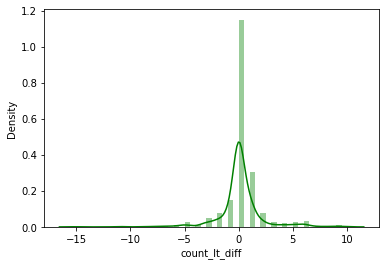

In [534]:
sns.distplot(df['count_lt_diff'], color='green');

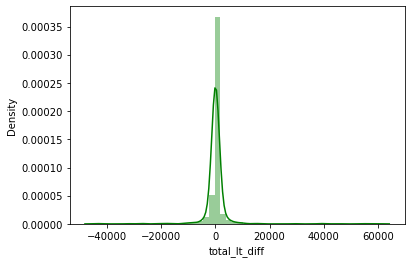

In [535]:
sns.distplot(df['total_lt_diff'], color='green')
sns.figsize = (100,100);
sns.xlim = (-2000,2000)

In [536]:
len(df['count_lt_diff'].unique())

22

In [537]:
len(df['total_lt_diff'].unique())

157

In [538]:
df['total_lt_diff'].value_counts().to_frame().head(10)

,total_lt_diff
0.0,445
500.0,34
-500.0,31
1000.0,29
100.0,26
300.0,23
-200.0,21
200.0,19
-100.0,19
-1000.0,14


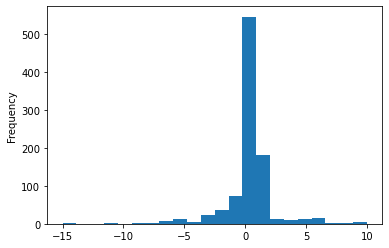

In [539]:
df['count_lt_diff'].plot(kind='hist', bins=22);

In [540]:
df['total_lt_diff'].describe().to_frame()

,total_lt_diff
count,949.000000
mean,176.566249
std,5320.243406
min,-44000.000000
25%,0.000000
50%,0.000000
75%,200.000000
max,60000.000000


## Подготовка датасета для ML

In [541]:
# классифицируем значения в столбце 'count_lt_diff'(разность между количеством пожертвований за первое и последнее полугодия lifetime)
# Значения :
# 0: -2 до 2 без изменений
# 1: >2 частота платежей увеличилась
# 3: <2  частота платежей уменьшилась
df['count_class'] = df['count_lt_diff'].apply(lambda x: 0 if ((x >= -2) and (x <= 2)) else(1 if x > 2 else -1))

# классифицируем значения в столбце 'total_lt_diff'(разность между общей суммой пожертвований за первое и последнее полугодия lifetime)
# Значения :
# 0: -200 до 200 без изменений
# 1: >200 сумма платежей увеличилась
# 3: <200  сумма платежей уменьшилась
#df['count_class'] = df['count_lt_diff'].apply(lambda x: 0 if ((x > -2) and (x < 2)) else(1 if x > 2 else -1))
df['total_class'] = df['total_lt_diff'].apply(lambda x: 0 if ((x >= -200) and (x <= 200)) else (1 if x >200 else -1))

df.head(2)

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,count_class,total_class
0,DE5393F9-9585-4057-B7FB-24B69697FC08,женский,Москва,21,3500.0,166.666667,100.0,73.080738,1,550.0,...,500.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0,1
1,81CD4BEF-443E-4D36-B34F-664E11182D65,женский,Москва,11,4200.0,381.818182,400.0,28.203597,0,931.0,...,500.0,0.181818,0.636364,0.0,0.181818,0.181818,0.818182,0.0,0,1


In [542]:
# процент лучших показателей (лучшие 11)
df[(df['total_class']==1) & (df['count_class']==1)]['id'].count()/df['id'].count()

0.05374077976817703

In [543]:
# количество лучших не ушедших жертвователей (последний платеж до полугода назад)
df[(df['total_class']==1) & (df['count_class']==1) & (df['last_donation']<182)]['id'].count()

42

In [544]:
#добавим столбец с целевым признаком
#df['class'] = 0

#for i in range(len(df['id'])):
#    if (df.loc[i]['total_class'] == 1) & (df.loc[i]['count_class'] == 1):
#        df.loc[i]['class'] = 1
#    else:
#        df.loc[i]['class'] = -1
#df.sample(2)

In [545]:
#добавим столбец с целевым признаком
df['class'] = df.count_class.map(str)\
+ df.total_class.map(str)

#удалим лишние столбцы
df = df.drop(['total_class', 'count_class'], axis=1)

df.sample(5)

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,class
830,CBE45716-C433-47A9-9492-CDB39FFCD325,женский,Москва,3,1300.0,433.333333,500.0,28.167972,0,740.0,...,0,-200.0,0.666667,0.0,0.0,0.333333,0.666667,0.333333,0.0,00
929,7A523B56-60CF-4A97-B841-1375096739DD,мужской,Город неизвестен,2,60.0,30.000000,30.0,0.000000,0,66.0,...,0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,1.0,00
704,827C2407-B3D5-4725-97C6-342629BE7E44,женский,Город неизвестен,2,800.0,400.000000,400.0,25.314198,0,63.0,...,0,0.0,1.000000,0.0,0.0,0.000000,1.000000,0.000000,0.0,00
500,4A3BFF44-A4FF-46CA-9CA7-4A66A380E6EF,женский,Город неизвестен,3,8000.0,2666.666667,1500.0,27.881293,0,160.0,...,0,0.0,1.000000,0.0,0.0,0.000000,1.000000,0.000000,0.0,00
655,4F321FC9-92FD-4FB2-9DE7-8D2867A2BBB4,женский,Город неизвестен,11,1100.0,100.000000,100.0,439.095101,1,306.0,...,0,0.0,1.000000,0.0,0.0,0.000000,1.000000,0.000000,0.0,00


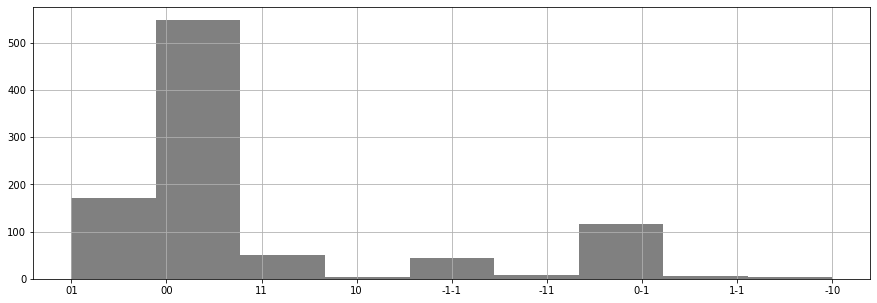

In [546]:
df['class'].hist(bins=9, figsize = (15,5), color='gray');

In [547]:
df['class'].unique()

array(['01', '00', '11', '10', '-1-1', '-11', '0-1', '1-1', '-10'],
      dtype=object)

In [548]:
df[df['class']=='-11']

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,class
37,E85E70D9-6809-4E1C-AE25-0EC489934DDC,мужской,Москва,34,4300.0,126.470588,100.0,28.237775,1,1813.0,...,-3,600.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11
134,193FBEF8-9C3E-4581-BBDF-A5D3EF653AE1,мужской,Москва,62,34500.0,556.451613,500.0,28.237798,1,2009.0,...,-3,500.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11
164,07923DBB-392D-4448-8117-E769F52AA476,женский,Город неизвестен,34,20300.0,597.058824,300.0,28.237763,1,1342.0,...,-3,9200.0,0.970588,0.0,0.029412,0.000000,1.000000,0.0,0.000000,-11
179,22BDC942-B82B-4004-ADFC-7787F780FB60,мужской,Москва,8,2125.0,265.625000,100.0,28.237775,1,551.0,...,-4,525.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11
226,64AE2C89-F75D-46C4-811C-CF199C3A43C9,женский,Другие города России,33,8300.0,251.515152,200.0,27.838608,1,2397.0,...,-4,800.0,0.969697,0.0,0.000000,0.030303,0.969697,0.0,0.030303,-11
234,69613503-5B71-4690-ACB5-8E783FF915B4,мужской,Город неизвестен,23,15500.0,673.913043,500.0,0.000000,0,462.0,...,-3,1500.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,-11
654,214CC544-A5CE-4E6E-B3BD-B2CC5396C5A0,женский,Город неизвестен,13,26500.0,2038.461538,1000.0,28.237775,1,1010.0,...,-5,8500.0,1.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,-11


In [549]:
# разобьем жертвователей на 4 класса
# - 1 -- уменьшившие сумму и/или частоту пожертвований;
# 0 -- не изменившие сумму и частоту пожертвований;
# 1 -- увеличившие сумму или частоту пожертвований;
# 2 -- увеличившие сумму и частоту пожертвований

df['class'] = df['class'].replace(['11'],2)
df['class'] = df['class'].replace(['01','10','-11','1-1'],1)
df['class'] = df['class'].replace('00', 0)
df['class'] = df['class'].replace(['-1-1','-10','0-1'],-1)
df['class'].unique()

array([ 1,  0,  2, -1])

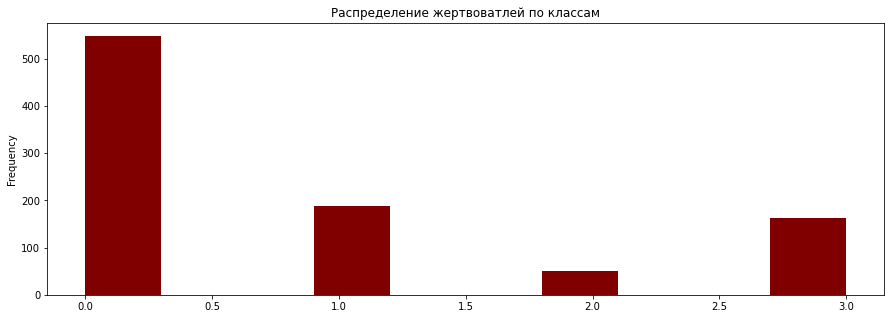

In [509]:
df['class'].plot(title='Распределение жертвоватлей по классам', kind='hist', figsize=(15,5), color='maroon');

In [510]:
df['class'].value_counts().to_frame()

,class
0,548
1,188
3,162
2,51


## Подготовим выборки для ML

## Кодирование

In [511]:
df.columns

Index(['id', 'gender', 'city_category', 'donations_count', 'donations_sum',
       'donations_mean', 'donations_median', 'last_email_activity',
       'is_reccurent', 'lifetime', 'period', 'first_donation', 'last_donation',
       'count_lt_diff', 'total_lt_diff', 'пожертвование', 'sms_purpose',
       'именное пожертвование', 'назнчение не указано', 'банковские карты',
       'sms_channel', 'прямые поступления на счет', 'class'],
      dtype='object')

In [512]:
columns = ['is_reccurent', 
       'gender', 
       'city_category']

for i in columns:
    df[i] = (df[i]).astype('category')

#df['class'] = RFM_Segment['RFMClass'].astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          949 non-null    object  
 1   gender                      949 non-null    category
 2   city_category               949 non-null    category
 3   donations_count             949 non-null    int64   
 4   donations_sum               949 non-null    float64 
 5   donations_mean              949 non-null    float64 
 6   donations_median            949 non-null    float64 
 7   last_email_activity         949 non-null    float64 
 8   is_reccurent                949 non-null    category
 9   lifetime                    949 non-null    float64 
 10  period                      949 non-null    float64 
 11  first_donation              949 non-null    float64 
 12  last_donation               949 non-null    float64 
 13  count_lt_diff       

In [513]:
for i in columns:
    df[i] = (df[i]).cat.codes

df.head(2)

,id,gender,city_category,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет,class
0,DE5393F9-9585-4057-B7FB-24B69697FC08,1,3,21,3500.0,166.666667,100.0,73.080738,1,550.0,...,-1,500.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,1
1,81CD4BEF-443E-4D36-B34F-664E11182D65,1,3,11,4200.0,381.818182,400.0,28.203597,0,931.0,...,0,500.0,0.181818,0.636364,0.0,0.181818,0.181818,0.818182,0.0,1


In [514]:
df = df.drop('id', axis=1)

In [515]:
# разделим данные на выборки
target = df['class']
features = df.drop('class', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, 
    test_size=0.25, 
    random_state=12345)

In [551]:
# функция для предсказания и вычисления accucacy
def accuracy(model):
    predictions = model.predict(features_test)
    print('Accuracy:', accuracy_score(predictions, target_test))
    #print('ROC AUC:', roc_auc_score(predictions, target_test), multi_class="ovr",average=None)

In [552]:
# CatBoost

#выделим категориальные признаки для бустинга
cat_features = ['is_reccurent',  'gender']

model1 = CatBoostClassifier(iterations=150, random_state = 12345)
model1.fit(features_train, target_train, cat_features=cat_features, verbose=0)
accuracy(model1)

Accuracy: 0.9957983193277311


In [553]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier()
model2.fit(features_train, target_train)
accuracy(model2)


Accuracy: 0.9747899159663865


In [ ]:
# обучим и проверим модели на другой выборке

In [562]:
features_train2, features_test2, target_train2, target_test2 = train_test_split(
    features, target, 
    test_size=0.4, 
    random_state=12345)

In [563]:
# функция для предсказания и вычисления accucacy по второму разделению на выборки
def accuracy2(model):
    predictions2 = model.predict(features_test2)
    print('Accuracy:', accuracy_score(predictions2, target_test2))

In [564]:
model12 = CatBoostClassifier(iterations=150, random_state = 12345)
model12.fit(features_train2, target_train2, cat_features=cat_features, verbose=0)
accuracy2(model12)

Accuracy: 0.9973684210526316


In [565]:
model22 = RandomForestClassifier()
model22.fit(features_train2, target_train2)
accuracy2(model22)

Accuracy: 0.9763157894736842


### Проверка на случайной выборке

In [380]:
target_random = []
for i in range(len(target_test)):
    target_random.append(0)


def accuracy_random(model):
    predictions_random = model.predict(features_test)
    print('Accuracy:', accuracy_score(predictions_random, target_random))

In [566]:
accuracy_random(model1)

Accuracy: 0.5798319327731093


In [567]:
accuracy_random(model2)

Accuracy: 0.5882352941176471


### Кросс-валидация

In [ ]:
def smape_unweighted(y_true, y_pred):
    error = abs(y_true - y_pred)
    scale = (abs(y_true) + abs(y_pred)) / 2 + 0.000000001
    result = (error / scale).mean()
    return result

def smape_weighted(smape_rougher, smape_final):
    final_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return final_smape


from sklearn.metrics import make_scorer
model_11 = LinearRegression()
smape_score = make_scorer(smape_unweighted, greater_is_better=False)
scores = sum(cross_val_score(model_11, features1, target1, scoring = smape_score, cv = 5))/5
smape_rougher = scores
warnings.filterwarnings('ignore')
scores

In [569]:
# кросс-валидация
from sklearn.model_selection import cross_val_score # кросс-валидация
from sklearn.metrics import make_scorer
accuracy_score = make_scorer(accuracy)
#scores = sum(cross_val_score(model1, features, target, scoring=accuracy_score, cv=5))/5
#scores